In [1]:
import demo_util
import numpy as np
import torch
from PIL import Image
import imagenet_classes
from IPython.display import display
import os
from huggingface_hub import hf_hub_download

/private/task/jwn/anaconda3/envs/1D_tokeniser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # downloads from hf
# hf_hub_download(repo_id="fun-research/TiTok", filename="tokenizer_titok_l32.bin", local_dir="./")
# hf_hub_download(repo_id="fun-research/TiTok", filename="generator_titok_l32.bin", local_dir="./")

# # or alternatively, from google drive
# # if not os.path.exists("tokenizer_titok_l32.bin"):
# #     os.system("gdown 1I_m2Vm4JgQsa7bZVORj-nVhP8fgQLngd")
# # if not os.path.exists("generator_titok_l32.bin"):
# #     os.system("gdown 1IgqZ_vwGIj2ZWOPuCzilxeQ2UrMVY93l")

In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.manual_seed(0)

## Prepare the TiTok models

In [2]:
config = demo_util.get_config("configs/titok_l32.yaml")

In [4]:
print(config)

{'experiment': {'tokenizer_checkpoint': 'ckpt/tokenizer_titok_l32.bin', 'generator_checkpoint': 'ckpt/generator_titok_l32.bin'}, 'model': {'vq_model': {'codebook_size': 4096, 'token_size': 12, 'use_l2_norm': True, 'commitment_cost': 0.25, 'vit_enc_model_size': 'large', 'vit_dec_model_size': 'large', 'vit_enc_patch_size': 16, 'vit_dec_patch_size': 16, 'num_latent_tokens': 32}, 'generator': {'dropout': 0.1, 'attn_drop': 0.1, 'num_steps': 8, 'mask_schedule_strategy': 'arccos', 'class_label_dropout': 0.1, 'image_seq_len': '${model.vq_model.num_latent_tokens}', 'condition_num_classes': 1000}}, 'dataset': {'preprocessing': {'crop_size': 256}}}


In [5]:
titok_tokenizer = demo_util.get_titok_tokenizer(config)
# print(titok_tokenizer)

In [6]:
titok_generator = demo_util.get_titok_generator(config)
# print(titok_generator)

In [7]:
device = "cuda"

In [8]:
titok_tokenizer = titok_tokenizer.to(device)
titok_generator = titok_generator.to(device)

## Tokenize and Reconstruct an image with 32 discrete tokens

In [9]:
# Tokenize an Image into 32 discrete tokens

def tokenize_and_reconstruct(img_path):
    original_image = Image.open(img_path)
    image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
    encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
    reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
    reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
    reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
    reconstructed_image = Image.fromarray(reconstructed_image)
    print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
    print("orginal image:")
    display(original_image)
    print("reconstructed image:")
    display(reconstructed_image)

Input Image is represented by codes tensor([[[1255, 2603,  982, 2222,  643, 1426,  866, 4094,  296, 1422,  398,
           764, 3670, 1265, 3986,  759, 1039, 3962, 2373, 2337, 1372, 4050,
          4012, 3644, 2624, 3735, 1539, 1289, 2817, 2985, 2550, 2972]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


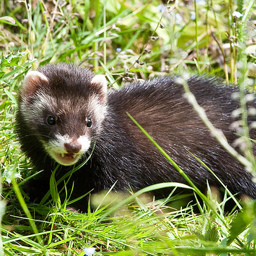

reconstructed image:


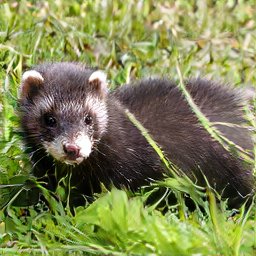

In [10]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00008636.png")

In [11]:
img_path = "assets/ILSVRC2012_val_00010240.png"
original_image = Image.open(img_path)
image = torch.from_numpy(np.array(original_image).astype(np.float32)).permute(2, 0, 1).unsqueeze(0) / 255.0
encoded_tokens = titok_tokenizer.encode(image.to(device))[1]["min_encoding_indices"]
reconstructed_image = titok_tokenizer.decode_tokens(encoded_tokens)
reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
reconstructed_image = Image.fromarray(reconstructed_image)
# print(f"Input Image is represented by codes {encoded_tokens} with shape {encoded_tokens.shape}")
# print("orginal image:")
# display(original_image)
# print("reconstructed image:")
# display(reconstructed_image)

tensor([[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 0, 0, 0, 0, 0, 1, 1]]], device='cuda:0')


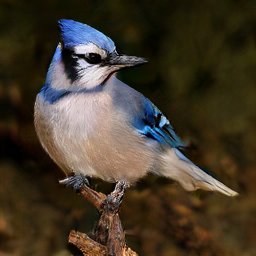

30


In [12]:
Mask = torch.zeros_like(encoded_tokens,device=device)
for i in range(0,32):
    Mask[0,0,i] = 1
# print(Mask)
for i in range(25,30):
    Mask[0,0,i] = 0
print(Mask)
masked_encoded_tokens = encoded_tokens * Mask
reconstructed_image = titok_tokenizer.decode_tokens(masked_encoded_tokens)
reconstructed_image = torch.clamp(reconstructed_image, 0.0, 1.0)
reconstructed_image = (reconstructed_image * 255.0).permute(0, 2, 3, 1).to("cpu", dtype=torch.uint8).numpy()[0]
reconstructed_image = Image.fromarray(reconstructed_image)
display(reconstructed_image)
print(i+1)

Input Image is represented by codes tensor([[[ 887, 3979,  349,  720, 2809, 2743, 2101,  603, 2205, 1508, 1891,
          4015, 1317, 2956, 3774, 2296,  484, 2612, 3472, 2330, 3140, 3113,
          1056, 3779,  654, 2360, 1901, 2908, 2169,  953, 1326, 2598]]],
       device='cuda:0') with shape torch.Size([1, 1, 32])
orginal image:


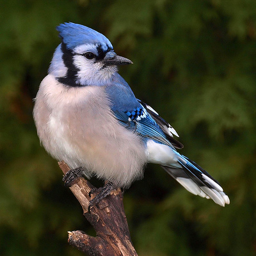

reconstructed image:


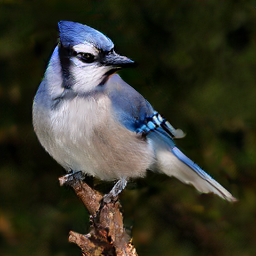

In [14]:
tokenize_and_reconstruct("assets/ILSVRC2012_val_00010240.png")

## Generate an image from 32 discrete tokens

labels 831, studio couch, day bed


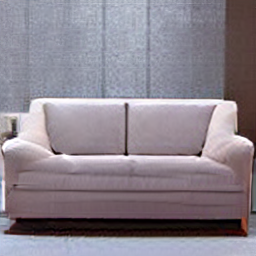

In [15]:
sample_labels = [torch.randint(0, 999, size=(1,)).item()]

# The guidance_scale and randomize_temperature can be adjusted to trade-off between quality and diversity.
generated_image = demo_util.sample_fn(
    generator=titok_generator,
    tokenizer=titok_tokenizer,
    labels=sample_labels,
    guidance_scale=3.5,
    randomize_temperature=1.0,
    num_sample_steps=8,
    device=device
)

for i in range(generated_image.shape[0]):
    print(f"labels {sample_labels[i]}, {imagenet_classes.imagenet_idx2classname[sample_labels[i]]}")
    display(Image.fromarray(generated_image[i]))